BOUGHT ETH FOR 0.1
SOLD ETH FOR 0.1
BOUGHT ETH FOR 0.1
SOLD ETH FOR 0.1
BOUGHT ETH FOR 0.1
SOLD ETH FOR 0.1
BOUGHT ETH FOR 0.1
SOLD ETH FOR 0.1
TOTAL PnL: 0.0$


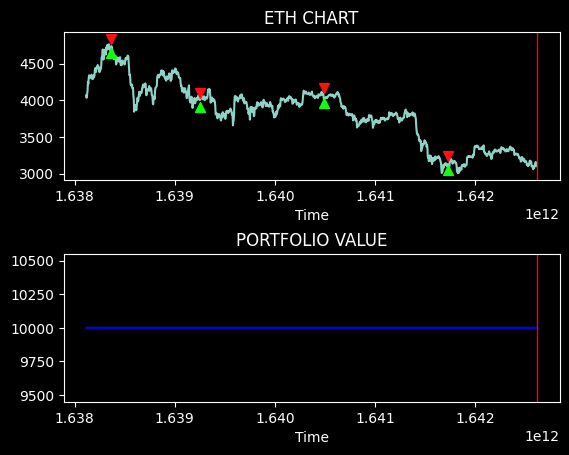

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("dark_background")


df=pd.read_csv("ETHUSDT_1h.csv").iloc[::-1]
# df["timestamp"] = pd.to_datetime(df["timestamp"])
plt.subplots_adjust(hspace=0.5)

buy_data = [[1640484000000, 4064.62], [1639249200000, 4004.01], [1638367200000, 4740.44], [1641726000000, 3148.24]]
BUY_SIGNAL = pd.DataFrame(buy_data, columns=["Timestamp", "Price"])
sell_data = [[1640484000000, 4064.62], [1639249200000, 4004.01], [1638367200000, 4740.44], [1641726000000, 3148.24]]
SELL_SIGNAL = pd.DataFrame(sell_data, columns=["Timestamp", "Price"])

buys = []

# Now we have to check if the row has a timestamp in the BUY_SIGNAL dataframe
# If so, update the balance amount by 10
money = 10000 # Giving myself 10K
imoney = money
asset = 0 # I own 0 ETH at first
buy_amount = 0.1
sell_amount = 0.1
for _, row in df.iterrows():
    # If theres a BUY_SIGNAL at this timestamp increase asset by 0.1 * asset price
    if row["timestamp"] in BUY_SIGNAL["Timestamp"].values:
        asset += buy_amount
        money -= buy_amount*row["close"]
        print("BOUGHT ETH FOR "+str(buy_amount))
    if row["timestamp"] in SELL_SIGNAL["Timestamp"].values:
        asset -= sell_amount
        money += sell_amount*row["close"]
        print("SOLD ETH FOR "+str(sell_amount))
    
    buys.append({"balance": money+(asset*row["close"])})
    # print("BALANCE: "+str(money))
print("TOTAL PnL: "+str(money-imoney)+"$")
PORTFOLIO = pd.DataFrame(buys)



# PRICE CHART
x1 = df["timestamp"]
y1 = df["close"]

#EMA LINES
ema100 = y1.ewm(span=100, adjust=False).mean()

plt.subplot(2,1,1)
plt.plot(x1,y1)
plt.axvline(x=df['timestamp'].iloc[-1], color="red", linestyle="-", linewidth=1)
plt.scatter(BUY_SIGNAL["Timestamp"], BUY_SIGNAL["Price"] - 100, color="#10ff10", s=50, marker="^", zorder=5)
plt.scatter(SELL_SIGNAL["Timestamp"], SELL_SIGNAL["Price"] + 100, color="#ff1010", s=50, marker="v", zorder=5)
plt.xlabel("Time")
plt.title("ETH CHART")

# PORTFOLIO BALANCE
x2 =  df["timestamp"]
y2 =  PORTFOLIO["balance"]
plt.subplot(2,1,2)
plt.plot(x2,y2,  color="blue")
plt.xlabel("Time")
plt.title("PORTFOLIO VALUE")
plt.axvline(x=df['timestamp'].iloc[-1], color="red", linestyle="-", linewidth=1)


plt.show()